### Accuracy

In [8]:
import pandas as pd
import torch
from random import *
import numpy as np
import math
import torch.utils.data as Data
import torch.nn as nn
import torch.optim as optim
import re
from tqdm import tqdm

train = pd.read_csv('data/Train.csv')

N = 500
batch_size = 100
token_size = 1000
MAX_DOC_LEN = 50
epoch_num = 100

use_gpu = torch.cuda.is_available()

In [4]:
##读取
import pickle

path = 'data/local_dict.pkl'
dict_file = open(path, 'rb')
vocab  = pickle.load(dict_file)[0]
print('length of vocabulary: ',len(vocab))
dict_file.close()
                    
word2idx = {'[PAD]' : 0, '[CLS]' : 1, '[MASK]' : 2}
for i, w in enumerate(vocab[:token_size]):
    word2idx[w] = i + 3
idx2word = {i: w for i, w in enumerate(word2idx)}

vocab_size=len(idx2word)
word_list = word2idx.keys()

# 模型参数
maxlen = MAX_DOC_LEN + 1 # 输入文本的最大词长度，与padding相关
max_pred = MAX_DOC_LEN + 1 # 最大预测词长度，需要padding和mask
n_layers = 6
n_heads = 6
d_k = d_v = 32  # dimension of K(=Q), V
d_model = n_heads * d_v # equal to n_heads * d_v
d_ff = d_model*4 # 4*d_model, FeedForward dimension

def make_data(token_list,labels,N):
    batch = []
    for ids in range(N):
        input_ids = [word2idx['[CLS]']] + token_list[ids]
        n_pred =  min(max_pred, max(1, int(len(input_ids) * 0.15))) # 15 % of tokens in one sentence
        cand_maked_pos = [i for i, token in enumerate(input_ids)
                          if token != word2idx['[CLS]']] # candidate masked position
        shuffle(cand_maked_pos)
        masked_tokens, masked_pos = [], []
        for pos in cand_maked_pos[:n_pred]:
            masked_pos.append(pos) # 被遮盖单词的位置
            masked_tokens.append(input_ids[pos]) # 被遮盖单词的tokens
            if random() < 0.8:  # 80%
                input_ids[pos] = word2idx['[MASK]'] # make mask
            elif random() > 0.9:  # 10%
                index = randint(0, vocab_size - 1) # random index in vocabulary
                while index < 3: # can't involve 'CLS', 'MASK', 'PAD'
                    index = randint(0, vocab_size - 1)
                input_ids[pos] = index # replace
        
        # Zero Paddings
        n_pad = maxlen - len(input_ids)
        input_ids.extend([0] * n_pad)

        # Zero Padding (100% - 15%) tokens
        if max_pred > n_pred:
            n_pad = max_pred - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)
            
        batch.append([input_ids,masked_tokens, masked_pos,labels[ids],ids])
        
    return batch

class MyDataSet(Data.Dataset):
    def __init__(self, input_ids, masked_tokens, masked_pos,label):
        self.input_ids = input_ids
        self.masked_tokens = masked_tokens
        self.masked_pos = masked_pos
        self.label = label
  
    def __len__(self):
        return len(self.input_ids)
  
    def __getitem__(self, idx):
        return self.input_ids[idx], self.masked_tokens[idx], self.masked_pos[idx], self.label[idx]

def get_attn_pad_mask(seq_q, seq_k):
    batch_size, seq_len = seq_q.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_q.data.eq(0).unsqueeze(1)  # [batch_size, 1, seq_len]
    return pad_attn_mask.expand(batch_size, seq_len, seq_len)  # [batch_size, seq_len, seq_len]

def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

def TanhMax(a):
    return (torch.exp(a) - torch.exp(-a)) / (torch.exp(a) + torch.exp(-a)).sum(dim=-1).unsqueeze(dim=-1)

class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(maxlen, d_model)  # position embedding
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long)
        pos = pos.unsqueeze(0).expand_as(x).cuda()  # [seq_len] -> [batch_size, seq_len]
        embedding = self.tok_embed(x) + self.pos_embed(pos) 
        pos.cpu()
        return self.norm(embedding)

class Attention(nn.Module):
    def __init__(self,act_type='TanhMax'):
        super(Attention, self).__init__()
        self.act_type = act_type

    def forward(self, Q, K, V, attn_mask):
        if act_type.lower() == 'tanhmax':
            scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size, n_heads, seq_len, seq_len]
            attn = TanhMax(scores)
            attn.masked_fill(attn_mask,0.0)
            context = torch.matmul(attn, V)
            return context
        else:
            scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size, n_heads, seq_len, seq_len]
            scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
            attn = nn.Softmax(dim=-1)(scores)
            context = torch.matmul(attn, V)
            return context

class MultiHeadAttention(nn.Module):
    def __init__(self,act_type='TanhMax'):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
        self.linear = nn.Linear(n_heads * d_v, d_model)
        self.layernorm = nn.LayerNorm(d_model)
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size, seq_len, d_model], k: [batch_size, seq_len, d_model], v: [batch_size, seq_len, d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size, n_heads, seq_len, d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size, n_heads, seq_len, d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size, n_heads, seq_len, d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size, n_heads, seq_len, seq_len]

        # context: [batch_size, n_heads, seq_len, d_v], attn: [batch_size, n_heads, seq_len, seq_len]
        context = Attention(act_type=act_type)(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size, seq_len, n_heads * d_v]
        output = self.linear(context)
        return self.layernorm(output + residual) # output: [batch_size, seq_len, d_model]

class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # (batch_size, seq_len, d_model) -> (batch_size, seq_len, d_ff) -> (batch_size, seq_len, d_model)
        return self.fc2(gelu(self.fc1(x)))
    
class EncoderLayer(nn.Module):
    def __init__(self,act_type='TanhMax'):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(act_type=act_type)
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size, seq_len, d_model]
        return enc_outputs

class Model(nn.Module):
    def __init__(self,act_type='TanhMax'):
        super(Model, self).__init__()
        self.embedding = Embedding()
        self.layers = nn.ModuleList([EncoderLayer(act_type=act_type) for _ in range(n_layers)])
        self.linear = nn.Linear(d_model, d_model)
        self.activ = gelu
        # fc2 is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        self.fc = nn.Linear(d_model, vocab_size, bias=False)
        self.fc.weight = embed_weight
        self.dense = nn.Linear(vocab_size,2)

    def forward(self, input_ids, masked_pos):
        output = self.embedding(input_ids) # [bach_size, seq_len, d_model]
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids) # [batch_size, maxlen, maxlen]
        for layer in self.layers:
            output = layer(output, enc_self_attn_mask)

        masked_pos = masked_pos[:, :, None].expand(-1, -1, d_model) # [batch_size, max_pred, d_model]
        h_masked = torch.gather(output, 1, masked_pos) # masking position [batch_size, max_pred, d_model]
        h_masked = self.activ(self.linear(h_masked)) # [batch_size, max_pred, d_model]
        logits_lm = self.fc(h_masked) # [batch_size, max_pred, vocab_size]
        logits_pred = self.dense(logits_lm[:,0,:])
        return logits_lm ,logits_pred

length of vocabulary:  16174


In [9]:
model = Model(act_type='TanhMax')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=0.001)

if(use_gpu):
    model = model.cuda()
    criterion = criterion.cuda()
    
X_train = train['text'].to_list()[:N]
y_train = train['label'].to_list()[:N]

doc_list = list()
for doc in X_train:
    temp = re.sub('[!?.,<>()""/]','',doc.lower())
    arr = [word2idx[s] if s in word_list else word2idx['[PAD]'] for s in temp.split(' ')[:MAX_DOC_LEN]]
    doc_list.append(arr)

batch = make_data(doc_list,y_train,N)
input_ids, masked_tokens, masked_pos, label, ids = zip(*batch)
input_ids, masked_tokens, masked_pos, label = \
    torch.LongTensor(input_ids),  torch.LongTensor(masked_tokens),\
    torch.LongTensor(masked_pos), torch.LongTensor(label)

loader = Data.DataLoader(MyDataSet(input_ids,masked_tokens, masked_pos, label), batch_size, True)


for epoch in tqdm(range(100)):
    for input_ids, masked_tokens, masked_pos, label in loader:
        input_ids = input_ids.cuda()
        masked_tokens = masked_tokens.cuda() 
        masked_pos = masked_pos.cuda() 
        label = label.cuda()
        
        logits_lm,logits_pred = model(input_ids, masked_pos)
        loss_lm = criterion(logits_lm.view(-1, vocab_size), masked_tokens.view(-1)) # for masked LM
        loss_lm = (loss_lm.float()).mean()
        loss_pred = criterion(nn.functional.softmax(logits_pred,dim=1), label)
        loss = loss_lm + loss_pred 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        input_ids = input_ids.cpu()
        masked_tokens = masked_tokens.cpu() 
        masked_pos = masked_pos.cpu() 
        label = label.cpu()

100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


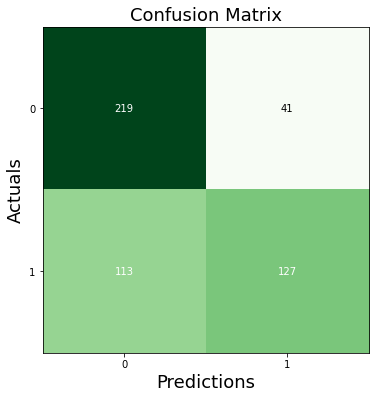

test accuracy:69.200%


In [10]:
import numpy as np
import math

model.eval()
with torch.no_grad():
    # 计算模型预测的准确率
    pred_labels = []
    true_labels = []
    for i in range(len(batch)):
        input_ids, masked_tokens, masked_pos, label, ids = batch[i]
        logits_lm,logits_pred = model(torch.LongTensor([input_ids]).cuda(), \
                     torch.LongTensor([masked_pos]).cuda())
        logits_pred = nn.functional.softmax(logits_pred,dim=1)
        #print(logits_pred.data.max(1)[1][0].tolist())
        logits_pred = logits_pred.data.max(1)[1][0].tolist()
        pred_labels.append(logits_pred)
        true_labels.append(label)

    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(true_labels, pred_labels)

    from mlxtend.plotting import plot_confusion_matrix
    import matplotlib.pyplot as plt

    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Greens)
    plt.rcParams['axes.unicode_minus'] = False 
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()
    
    accuracy = (cm[0][0] + cm[1][1]) / sum(sum(cm))
    print('test accuracy:{:.3f}%'.format(accuracy*100))

### test_accuracy

In [10]:
test = pd.read_csv('data/Test.csv')
X_test = train['text'].to_list()
y_test = train['label'].to_list()

In [11]:
test_doc_list = list()
for doc in X_test:
    temp = re.sub('[!?.,<>()""/]','',doc.lower())
    arr = [word2idx[s] if s in word_list else word2idx['[PAD]'] for s in temp.split(' ')[:MAX_DOC_LEN]]
    test_doc_list.append(arr)

test_batch = make_data(test_doc_list,y_test,N)
input_ids, masked_tokens, masked_pos, label, ids = zip(*test_batch)
input_ids, masked_tokens, masked_pos, label = \
    torch.LongTensor(input_ids),  torch.LongTensor(masked_tokens),\
    torch.LongTensor(masked_pos), torch.LongTensor(label)

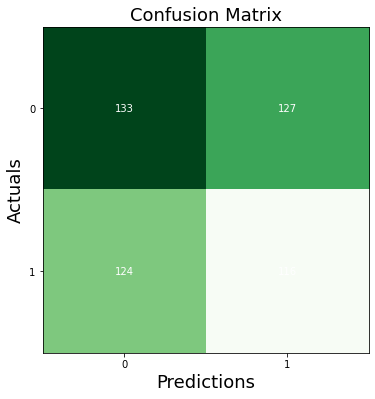

test accuracy:49.800%


In [12]:
model.eval()
with torch.no_grad():
    # 计算模型预测的准确率
    pred_labels = []
    true_labels = []
    for i in range(len(test_batch)):
        input_ids, masked_tokens, masked_pos, label, ids = test_batch[i]
        logits_lm,logits_pred = model(torch.LongTensor([input_ids]).cuda(), \
                     torch.LongTensor([masked_pos]).cuda())
        logits_pred = nn.functional.softmax(logits_pred,dim=1)
        #print(logits_pred.data.max(1)[1][0].tolist())
        logits_pred = logits_pred.data.max(1)[1][0].tolist()
        pred_labels.append(logits_pred)
        true_labels.append(y_test[i])

    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(true_labels, pred_labels)

    from mlxtend.plotting import plot_confusion_matrix
    import matplotlib.pyplot as plt

    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Greens)
    plt.rcParams['axes.unicode_minus'] = False 
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    #plt.savefig('result/model_cm.png')
    plt.show()
    
    accuracy = (cm[0][0] + cm[1][1]) / sum(sum(cm))
    print('test accuracy:{:.3f}%'.format(accuracy*100))
    